The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


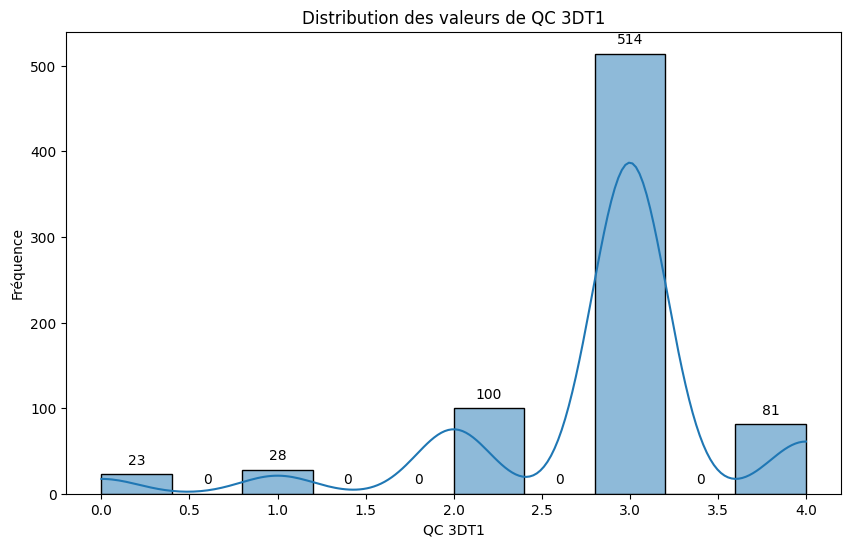

/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


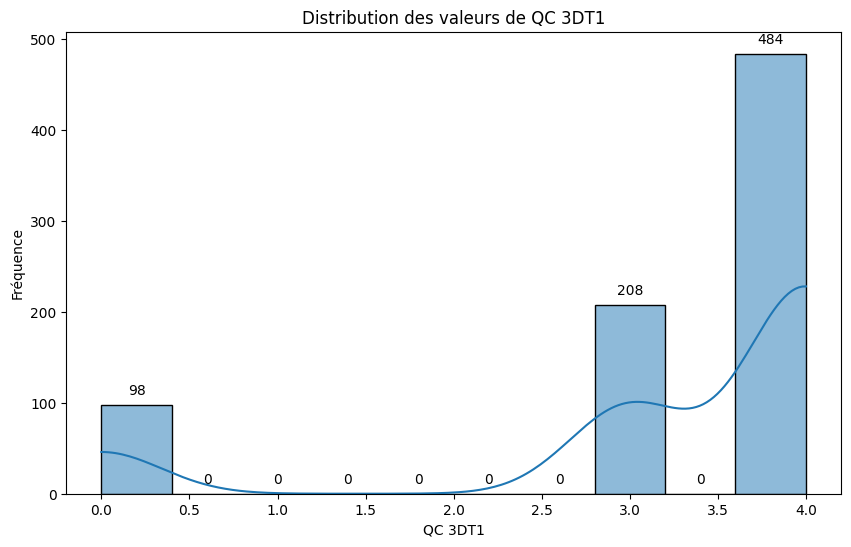

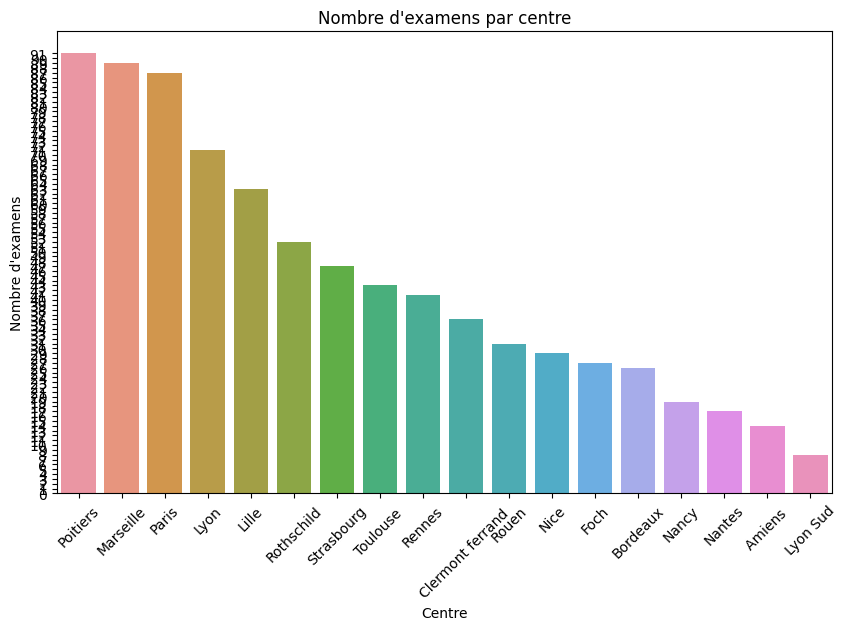

<Figure size 640x480 with 0 Axes>

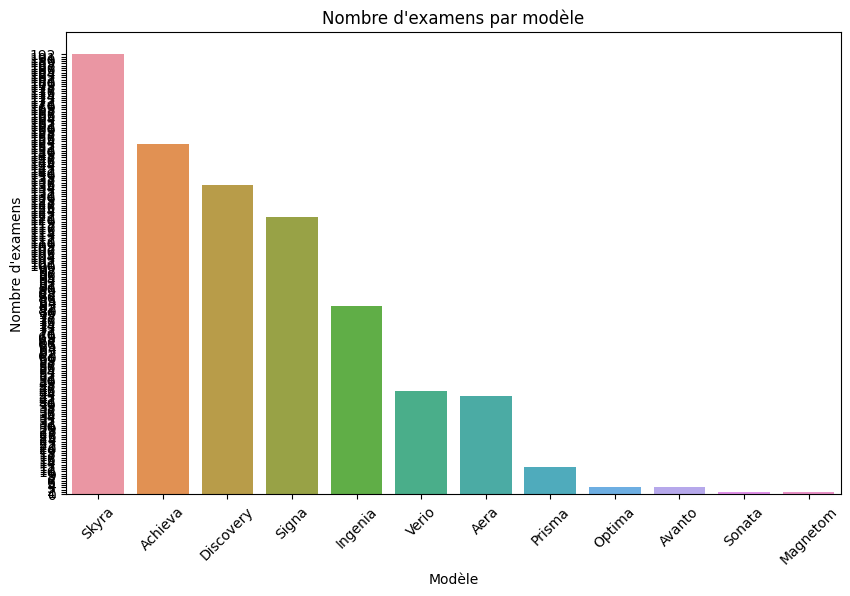

<Figure size 640x480 with 0 Axes>

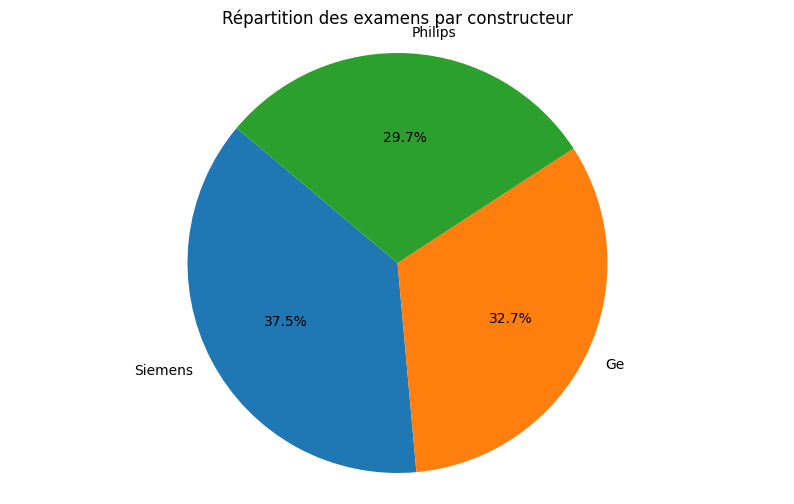

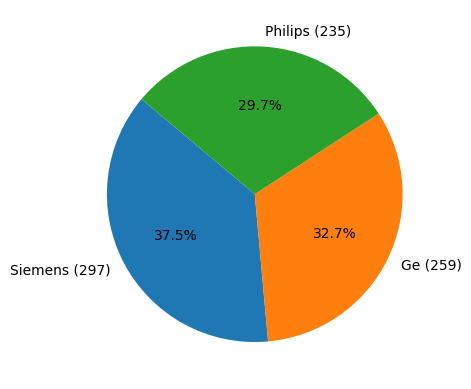

In [1]:
try:
    import import_ipynb
except :
    !pip install import_ipynb
    import import_ipynb
import Predistim_Library as pl

In [2]:
import os
import pandas as pd
from scipy.io import loadmat
import glob
from plotnine import ggplot, aes, geom_point, labs
import numpy as np
import matplotlib.pyplot as plt
from plotnine import ggplot, aes, geom_errorbar, geom_line, geom_point, labs, theme_minimal

# read mat files for building a dataframe

In [7]:
os.path.join(base_path, file_pattern)

'/NAS/deathrow/protocoles/predistim/20250707-120649_MAD_pdt2se/derivatives/mrGRAD_20250718/sub-*/mrGrad/mrGrad_t1overt2.mat'

In [ ]:
# Chemin vers les fichiers
base_path = "/NAS/deathrow/protocoles/predistim/20250707-120649_MAD_pdt2se/derivatives/mrGRAD_T1overT2/"
file_pattern = "sub-*/mrGrad/mrGrad_t1overt2.mat"

# Récupérer les chemins des fichiers
# Ensure glob_files function exists and works correctly
try:
    file_paths = glob.glob(os.path.join(base_path, file_pattern), recursive=True)
except AttributeError as e:
    print(f"Error: {e}. Ensure 'glob_files' is implemented in 'Predistim_Library'.")
    file_paths = []  # Fallback to an empty list if there's an error

# Initialiser une liste pour stocker les données
data = []

# Parcourir les fichiers et charger les données
for file_path in file_paths:
    #subject_name = os.path.basename(os.path.dirname(os.path.dirname(file_path)))  # Extraire le nom du sujet
    mat_data = loadmat(file_path)  # Charger le fichier .mat
    try:
        subject_names = str(mat_data['RG'][0][0]['subject_names'][0][0][0][0][0])
        print(subject_names)
        # Extract and store data with labels
        try:
            roi_label_0 = mat_data['RG'][0][0]['ROI_label'][0][0][0]
            roi_label_1 = mat_data['RG'][0][1]['ROI_label'][0][0][0]
            y_data_0 = np.array(mat_data['RG'][0][0]['Y'][0][0][0][0]).flatten()
            y_data_1 = np.array(mat_data['RG'][0][1]['Y'][0][0][0][0]).flatten()

            data.append({
                'subject_name': subject_names,
                f"{roi_label_0}_seg1": y_data_0[0],
                f"{roi_label_0}_seg2": y_data_0[1],
                f"{roi_label_0}_seg3": y_data_0[2],
                f"{roi_label_0}_seg4": y_data_0[3],
                f"{roi_label_0}_seg5": y_data_0[4],
                f"{roi_label_0}_seg6": y_data_0[5],
                f"{roi_label_0}_seg7": y_data_0[6],
                f"{roi_label_1}_seg1": y_data_1[0],
                f"{roi_label_1}_seg2": y_data_1[1],
                f"{roi_label_1}_seg3": y_data_1[2],
                f"{roi_label_1}_seg4": y_data_1[3],
                f"{roi_label_1}_seg5": y_data_1[4],
                f"{roi_label_1}_seg6": y_data_1[5],
                f"{roi_label_1}_seg7": y_data_1[6],
            })
        except KeyError as e:
            print(f"KeyError: {e}. Ensure 'ROI_label' and 'Y' exist in mat_data['RG'].")
    except KeyError as e:
        print(f"KeyError: {e}. 'subject_names' not found in mat_data['RG'].")
    #data.append({'subject_name': subject_name, 'data': mat_data})

# Créer un DataFrame
df = pd.DataFrame(data).set_index('subject_name')

# Clean index
df_cleaned = df.dropna()
df_cleaned.index = df_cleaned.index.str.replace("sub-", "", regex=False)
df_cleaned.index = df_cleaned.index.str.replace("_ses-M00", "", regex=False)
df_cleaned.index = df_cleaned.index.str.slice(0, 2).str.cat(df_cleaned.index.str.slice(2,-2), sep="-")

print(df_cleaned)

KeyError: "None of ['subject_name'] are in the columns"

In [5]:
mat_data

NameError: name 'mat_data' is not defined

## Calcul de l'index Putamen_axis1_seg_asym

In [ ]:
# Calculate asymmetry for each segment
for seg in range(1, n_segments + 1):
    left = df_cleaned[f"Left-Putamen_seg{seg}"]
    right = df_cleaned[f"Right-Putamen_seg{seg}"]
    asym = (left - right) / ((left + right) / 2)
    df_cleaned[f"Putamen_axis1_seg{seg}_asym"] = asym

# Calculate pp asymmetry for segments 1 to 3
pp_segments = [f"Putamen_axis1_seg{seg}_asym" for seg in range(1, 4)]
df_cleaned["pp_asym"] = df_cleaned[pp_segments].mean(axis=1)

/tmp/ipykernel_3403056/2275697852.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_3403056/2275697852.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Graphiques 

In [190]:
import seaborn as sns

# Create a histogram for the pp_asym column
fig_pp_asym = ff.create_distplot([df_cleaned["pp_asym"].dropna()], ['Asymetry T1overT2 seg 1 to 3'], colors=['blue'])

# Update layout with English labels
fig_pp_asym.update_layout(
    title="Distribution of Motor Symptom Asymmetry",
    xaxis_title="Values",
    yaxis_title="Density"
)

fig_pp_asym.show()


/tmp/ipykernel_3403056/3316590680.py:23: FutureWarning:

Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().



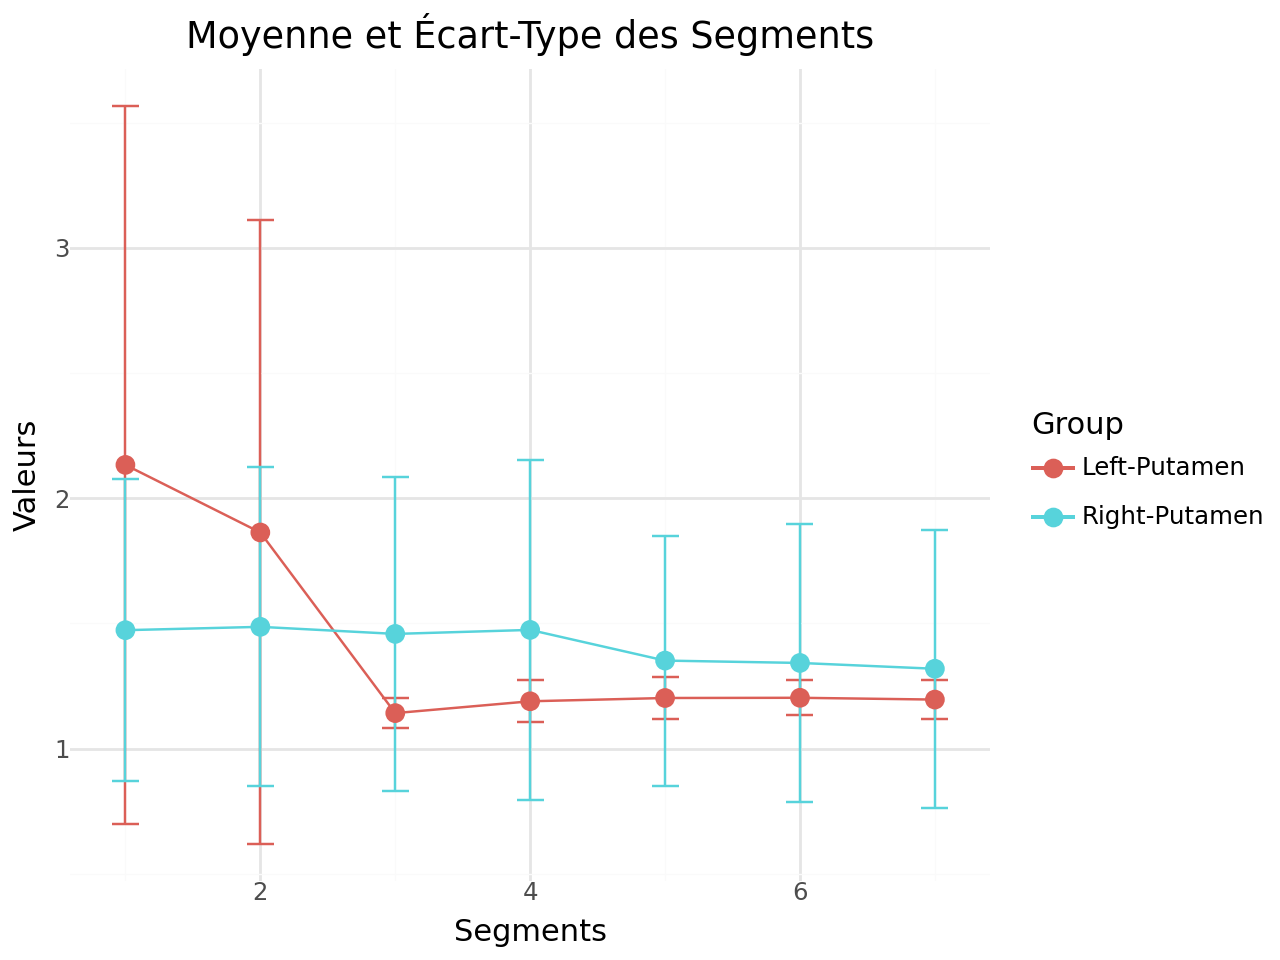

In [192]:
# Préparer les données pour ggplot
plot_data = pd.DataFrame({
    'Segment': list(segments) * 2,
    'Mean': pd.concat([left_putamen_mean, right_putamen_mean]).values,
    'Std': pd.concat([left_putamen_std, right_putamen_std]).values,
    'Group': ['Left-Putamen'] * n_segments + ['Right-Putamen'] * n_segments
})

# Créer le graphique avec ggplot
plot = (
    ggplot(plot_data, aes(x='Segment', y='Mean', color='Group')) +
    geom_errorbar(aes(ymin='Mean - 0.1*Std', ymax='Mean + 0.1*Std'), width=0.2) +
    geom_line() +
    geom_point(size=3) +
    labs(
        title="Moyenne et Écart-Type des Segments",
        x="Segments",
        y="Valeurs"
    ) +
    theme_minimal()
)

print(plot)


# Récuperer les valeurs UPDRS 

In [ ]:
#1
df_msa = pd.read_excel(os.path.join(pl.STUDY_PATH, "csv_xlsx", "Romain_Juin2025.xlsx"), engine='openpyxl',sheet_name='UPDRSIII_COMPLET_V0')
print(df_msa.head())
df_msa.set_index("SUBJID", inplace=True)

#2
# Afficher toutes les colonnes contenant "DROIT" dans leur nom
droit_columns = df_msa.filter(regex="OF.*_.*DROIT", axis=1).columns
#print(len(droit_columns),droit_columns)

# Afficher toutes les colonnes contenant "DROIT" dans leur nom
gauche_columns = df_msa.filter(regex="OF.*_.*GCHE", axis=1).columns

df_msa['somme_droit'] = df_msa[droit_columns].apply(pd.to_numeric, errors='coerce').sum(axis=1)
df_msa['somme_gauche'] = df_msa[gauche_columns].apply(pd.to_numeric, errors='coerce').sum(axis=1)
df_msa['asymetry'] = df_msa['somme_droit'] - df_msa['somme_gauche']
df_msa['asymetry'].dropna(inplace=False)

                             SUBJID                            V12H_APRES  \
0  Subject Identifier for the Study  réalisation après 12h d'arret L-Dopa   
1                            01-001                                   Oui   
2                            01-002                                   Oui   
3                            01-003                                   Oui   
4                            01-004                                   Oui   

                                  DEMIVIE_AGONISTE                   H_LDOPA  \
0  réalisation après 5 demie-vies d'arret agoniste  heure de prise de L Dopa   
1                                              Oui                     09:00   
2                                              Oui                     09:47   
3                                               .K                     09:00   
4                                              Oui                     09:25   

       DOSE_LDOPA      OFF_H       ON_H15       ON_H30  

In [176]:
# Update group labels to English
group_labels = ['Sum Right', 'Sum Left']

# Create the distribution plot with updated labels
fig = ff.create_distplot(data, group_labels, colors=['red', 'blue'])

# Update layout
fig.update_layout(
    title="Distribution of Sum Right and Sum Left",
    xaxis_title="Values",
    yaxis_title="Density"
)

fig.show()

# Create a histogram for the asymmetry column
fig_asym = ff.create_distplot([df_msa['asymetry'].dropna()], ['Asymmetry'], colors=['green'])

# Update layout with English labels
fig_asym.update_layout(
    title="Distribution of Asymmetry",
    xaxis_title="Values",
    yaxis_title="Density"
)

fig_asym.show()


/tmp/ipykernel_3403056/2614202777.py:19: FutureWarning:

Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().

/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning:

geom_point : Removed 7 rows containing missing values.



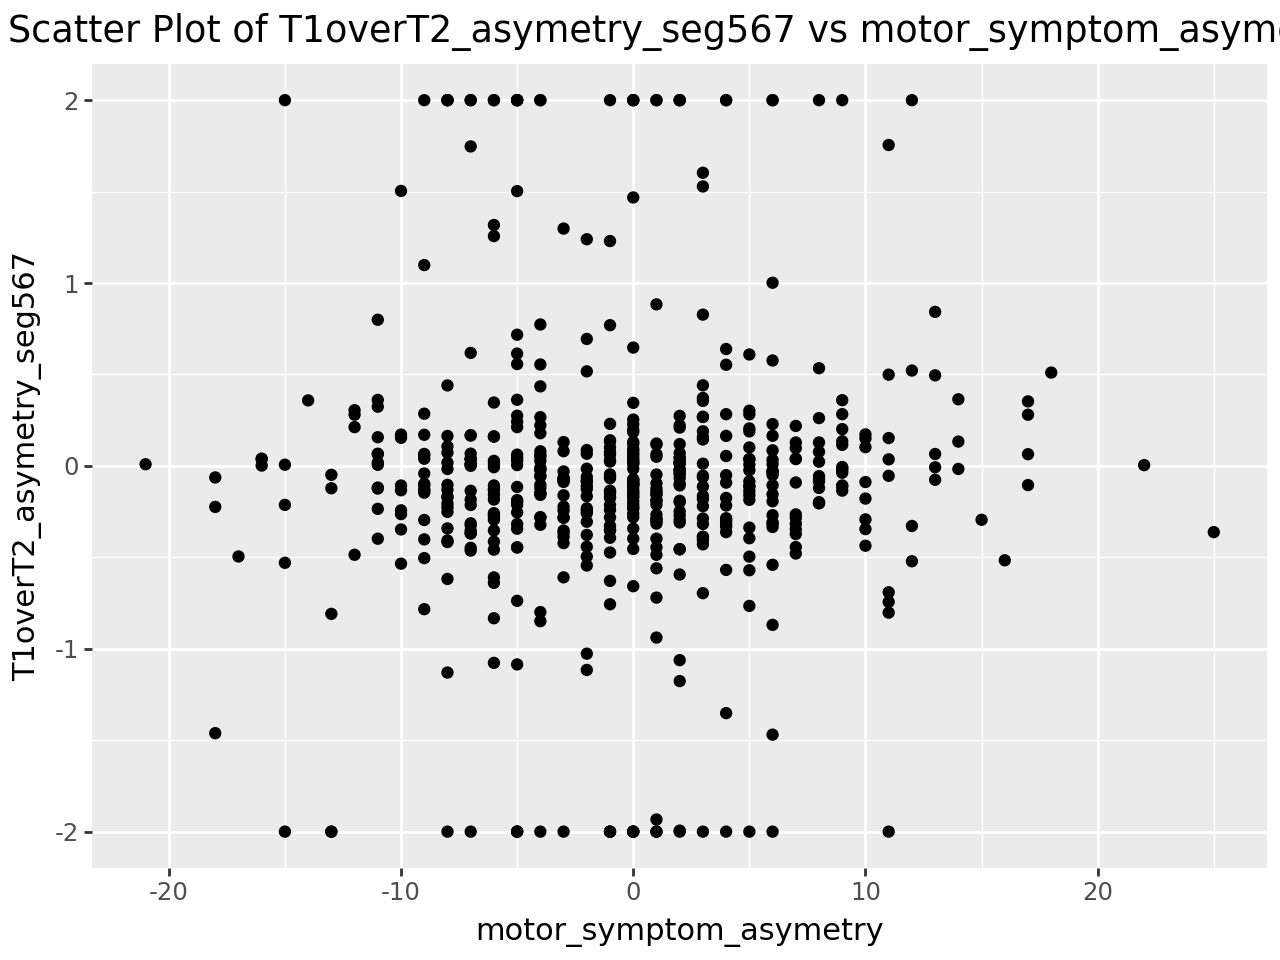

In [179]:
df_intersection = pd.DataFrame({
    'motor_symptom_asymetry': df_cleaned.loc[intersection_index, 'pp_asym'],
    'T1overT2_asymetry_seg123': df_msa.loc[intersection_index, 'asymetry']
})

#df_intersection_filtered = df_intersection[df_intersection.index.str.startswith("01-")]

# Create a scatter plot of pp_asym vs asymetry
plot = (
    ggplot(df_intersection, aes(x='T1overT2_asymetry_seg123', y='motor_symptom_asymetry')) +
    geom_point() +
    labs(
        title="Scatter Plot of T1overT2_asymetry_seg567 vs motor_symptom_asymetry",
        x="motor_symptom_asymetry",
        y="T1overT2_asymetry_seg567"
    )
)

print(plot)